# U Owns the Code and How Marginal Owners Resolve Issues Slower in Low-Quality Source Code

This is the Jupyter Notebook that contains the analyses for the corresponding paper.

# Prerequisites

This notebook uses various external libraries. In this section, we also define all helper functions.

In [1]:
# Import libraries and configure this notebook
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import math
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import effectsize_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import PowerTransformer

/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
# Set the colors used in this notebook
sns.set()
red_light = "#EE324C"
yellow_light = "#F2AC42"
green_light = "#00B38A"
traffic_colors = [green_light, yellow_light, red_light]
traffic_colors_r = [red_light, yellow_light, green_light]

In [4]:
# scaling and normalization for later ANOVA tests
def _scale(df, column_to_scale):
    max_v = df[column_to_scale].max()
    
    def v_to_scaled(v):
        return v / max(max_v, 1)
    
    scaled = [v_to_scaled(v) for v in df[column_to_scale]]
    df[column_to_scale + '_scaled'] = scaled
    return df

def _normalize_yj_transform(df, scaled_column_to_normalize):
    pt = PowerTransformer(method='yeo-johnson')
    
    data = np.array(df[scaled_column_to_normalize])
    reshaped_data = np.array(data).reshape(-1, 1)
    
    pt.fit(reshaped_data)
    df[scaled_column_to_normalize + '_norm'] = pt.transform(reshaped_data)
    return df

def scale_and_normalize_df(df, column_to_scale_and_norm):
    df = _scale(df, column_to_scale_and_norm)
    df = _normalize_yj_transform(df, column_to_scale_and_norm)
    return df

In [5]:
# the file's current Code Health
def _with_code_health_category(df):
    def v_to_category(v):
        if v < 4.0:
            return 'alert'
        if v < 9.0:
            return 'warning'
        return 'healthy'

    code_health_categories = [v_to_category(v) for v in df['code_health']]
    df['code_health_category'] = code_health_categories
    return df

# a developer's relative ownership of a file, i.e., his/her fraction of commits
def _with_ownership_category(df):
    def v_to_category(v):
        if v < 0.10:
            return 'marginal'
        if v < 0.5:
            return 'minor'
        if v < 0.9:
            return 'major'
        return 'dominant'
    
    knowledge_categories = [v_to_category(v) for v in df['module_ownership']]
    df['author_ownership_category'] = knowledge_categories
    return df

# the size of a modication
def _with_change_size(df):
    def v_to_category(v):
        if v < 5:
            return 'small'
        if v < 20:
            return 'medium'
        return 'large'

    added_loc_categories = [v_to_category(v) for v in df['added_loc']]
    df['added_loc_category'] = added_loc_categories
    return df

# Data wrangling

Read the CSV file and parse it into a Pandas data frame.

The parsed data frame contains rows of file+issue modifications. Note that one issue can impact multiple files, but the metrics are tracked at a file level. Each row contains the following variables:

* `programming-language`: The programming language according to the file extension.
* `contributing-months`: Codebase level metric depicting the number of months since the developer of this modification made the first commit to the repository.
* `contributing-months-relative-norm`: `contributing-months` scaled to the interval 0..1.0 across all repositories to allow cross-project comparisons.
* `date`: Date of the modification.
* `bug-fix`: Whether the modification is related to a Jira bug fix or feature development. Boolean.
* `lead-time-minutes`: the Time-in-Development in minutes (same as in Code Red) for each modification. 
* `module-ownership`: The developer's relative ownership of the modified file, i.e., his/her fraction of the commits.
* `added-loc`: The number of lines added in the modification. Set to 0 if the modification resulted in a LoC decrease.
* `code_health`: Code Health score of the file prior to the modification.
* `ticket-id`: Issure report identifier.

In [8]:
# The file name suffix shows the date for the data collection
raw_df = pd.read_csv('./data/u_owns_the_code_2022-12-28.csv', sep=';', decimal=".")
raw_df.describe()

,contributing_months_relative_norm,lead_time_minutes,module_ownership,contributing_months,added_loc,code_health
count,108235.000000,108969.000000,108969.000000,108969.000000,108969.000000,108969.000000
mean,0.809203,9350.557498,0.480542,19.442649,21.301122,9.503400
std,0.320360,26438.074341,0.384888,20.368511,98.350163,1.086215
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.676471,840.000000,0.094595,5.000000,2.000000,9.500000
50%,1.000000,3060.000000,0.406780,11.000000,5.000000,10.000000
75%,1.000000,7680.000000,0.920635,29.000000,18.000000,10.000000
max,1.000000,769860.000000,1.000000,95.000000,16166.000000,10.000000


## Data cleaning

Some values do not appear valid. We clean the data accordingly.

In [9]:
valid_df = raw_df[(raw_df['lead_time_minutes'] > 0) & (raw_df['added_loc'] > 0)]

valid_df.describe()

,contributing_months_relative_norm,lead_time_minutes,module_ownership,contributing_months,added_loc,code_health
count,101229.000000,101920.000000,101920.000000,101920.000000,101920.000000,101920.000000
mean,0.807504,9474.766484,0.488538,19.487451,22.704641,9.501826
std,0.320878,26675.248873,0.383921,20.468079,101.521710,1.090588
min,0.000000,60.000000,0.000000,0.000000,1.000000,1.000000
25%,0.666667,960.000000,0.102398,5.000000,2.000000,9.500000
50%,1.000000,3120.000000,0.419800,11.000000,6.000000,10.000000
75%,1.000000,7800.000000,0.926236,29.000000,20.000000,10.000000
max,1.000000,769860.000000,1.000000,95.000000,16166.000000,10.000000


We remove rows with outliers that are not covered by three standard deviations, i.e., 99.7% of the data is kept. Huge values are treated as noise.

In [10]:
# remove extremely long lead times and huge chunks of code
clean_df = valid_df[(np.abs(stats.zscore(raw_df['lead_time_minutes'])) < 3) & 
                    (np.abs(stats.zscore(raw_df['added_loc'])) < 3)]

clean_df.describe()

/var/folders/1g/r7vjn7113r5_v0rymj6kbtvr0000gn/T/ipykernel_21229/522454188.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = valid_df[(np.abs(stats.zscore(raw_df['lead_time_minutes'])) < 3) &


,contributing_months_relative_norm,lead_time_minutes,module_ownership,contributing_months,added_loc,code_health
count,98639.000000,99330.000000,99330.000000,99330.000000,99330.000000,99330.000000
mean,0.809869,6525.040773,0.486770,19.444891,19.093788,9.513291
std,0.319774,10634.522726,0.383434,20.566389,35.615756,1.076047
min,0.000000,60.000000,0.000000,0.000000,1.000000,1.000000
25%,0.676471,900.000000,0.101852,5.000000,2.000000,9.500000
50%,1.000000,2940.000000,0.416667,11.000000,6.000000,10.000000
75%,1.000000,7380.000000,0.923897,29.000000,19.000000,10.000000
max,1.000000,88320.000000,1.000000,95.000000,316.000000,10.000000


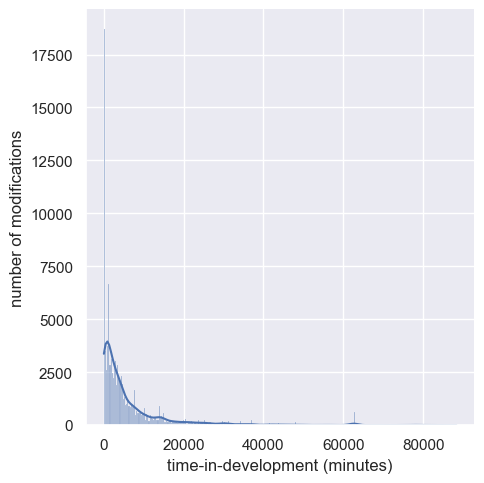

In [11]:
plot = sns.displot(data=clean_df['lead_time_minutes'], kde=True)
plt.xlabel("time-in-development (minutes)")
plt.ylabel("number of modifications")
plt.show(plot)

Some Jira issues are connected to very many modifications. This results in spikes at some values for time-in-development. As this biases our modifications-oriented data, we remove rows that are connected to Jira issues with >=50 modifications.

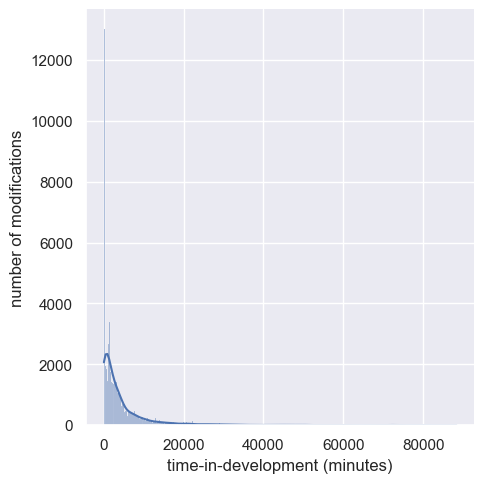

Total number of Jira issues: 7721


,contributing_months_relative_norm,lead_time_minutes,module_ownership,contributing_months,added_loc,code_health
count,55106.000000,55429.000000,55429.000000,55429.000000,55429.000000,55429.000000
mean,0.792280,4818.581609,0.440298,18.903877,18.860488,9.426824
std,0.330723,8717.604319,0.378571,21.169609,35.339686,1.180573
min,0.000000,60.000000,0.000000,0.000000,1.000000,1.000000
25%,0.631579,420.000000,0.076271,4.000000,2.000000,9.480000
50%,1.000000,2040.000000,0.329556,9.000000,6.000000,10.000000
75%,1.000000,5040.000000,0.852775,28.000000,19.000000,10.000000
max,1.000000,88320.000000,1.000000,95.000000,316.000000,10.000000


In [12]:
clean_df =  clean_df.groupby('ticket_id').filter(lambda x : len(x)<50)

plot = sns.displot(data=clean_df['lead_time_minutes'], kde=True)
plt.xlabel("time-in-development (minutes)")
plt.ylabel("number of modifications")
plt.show(plot)

unique_df = clean_df.drop_duplicates(subset=['ticket_id'])
print("Total number of Jira issues: " + str(len(unique_df)))

clean_df.describe()

The distribution looks smooth now, but some modifications still represent issues with very a very long development time. We choose to remove such outliers, i.e., we remove rows that correspond to resolution times longer than 10,140 minutes. This equals 167 hours, which represents a "mythical man month" for 2022 in the authors' country).

/var/folders/1g/r7vjn7113r5_v0rymj6kbtvr0000gn/T/ipykernel_21229/3191236209.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = clean_df[(raw_df['lead_time_minutes']) <= 10140]


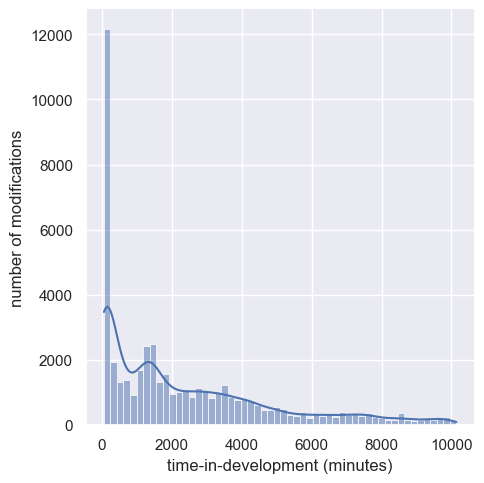

In [13]:
clean_df = clean_df[(raw_df['lead_time_minutes']) <= 10140]

plot = sns.displot(data=clean_df['lead_time_minutes'], kde=True)
plt.xlabel("time-in-development (minutes)")
plt.ylabel("number of modifications")
plt.show()

Now we consider the dataset clean. (Some columns removed to preserve confidentiality)

In [19]:
print("Basic statistics for the dataset")
#unique_df = clean_df.drop_duplicates(subset=['job'])
#print("Total number of repositories: " + str(len(unique_df)))
#unique_df = clean_df.drop_duplicates(subset=['module'])
#print("Total number of source code files: " + str(len(unique_df)))
unique_df = clean_df.drop_duplicates(subset=['ticket_id'])
print("Total number of Jira issues: " + str(len(unique_df)))
bug_issues = len(unique_df.loc[unique_df['bug_fix'] == True])
feature_issues = len(unique_df.loc[unique_df['bug_fix'] == False])
print("(Bug reports: " + str(bug_issues) + ", Feature requests: " + str(feature_issues) + ")")
#unique_df = clean_df.drop_duplicates(subset=['author'])
#print("Total number of developers: " + str(len(unique_df)))
unique_df = clean_df.drop_duplicates(subset=['programming_language'])
print("Total number of programming languages: " + str(len(unique_df)))

Basic statistics for the dataset
Total number of Jira issues: 7307
(Bug reports: 2428, Feature requests: 4879)
Total number of programming languages: 23


## Data categorization

We introduce discrete levels for Code Health, Ownership, and Change Size.

In [20]:
df = _with_ownership_category(_with_code_health_category(_with_change_size(clean_df)))

## Descriptive statistics and visualizations of the dataset

First, we look at how many modifications we have to files representing different levels of Code Health:

In [21]:
clean_df['code_health_category'].value_counts()
#clean_df['code_health_category'].value_counts(normalize=True)

healthy    41361
warning     7100
alert        506
Name: code_health_category, dtype: int64

Second, we look at how many modifications we have corresponding developers' different levels of ownership for the modified file:

In [22]:
clean_df['author_ownership_category'].value_counts()
#clean_df['author_ownership_category'].value_counts(normalize=True)

minor       14920
marginal    14266
dominant    10909
major        8872
Name: author_ownership_category, dtype: int64

In [23]:
clean_df['added_loc_category'].value_counts()
clean_df['added_loc_category'].value_counts(normalize=True)

small     0.446015
medium    0.320604
large     0.233382
Name: added_loc_category, dtype: float64

Third, we plot various distributions to get an overview of the data:

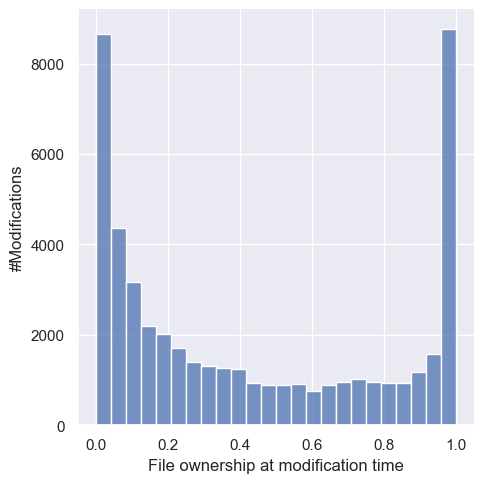

In [25]:
sns.displot(clean_df['module_ownership'])
plt.xlabel("File ownership at modification time")
plt.ylabel("#Modifications")
plt.show()

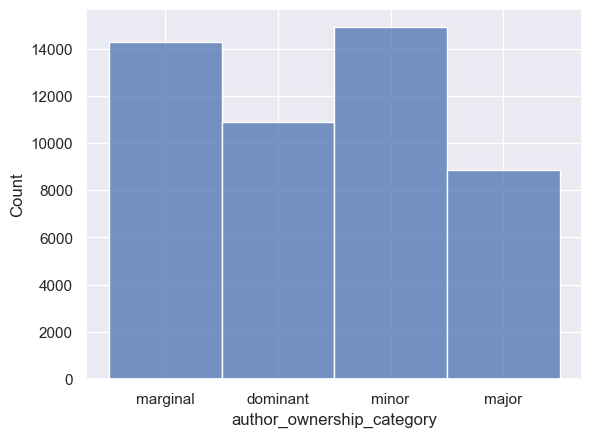

In [26]:
sns.histplot(x="author_ownership_category", data=clean_df)
plt.show()

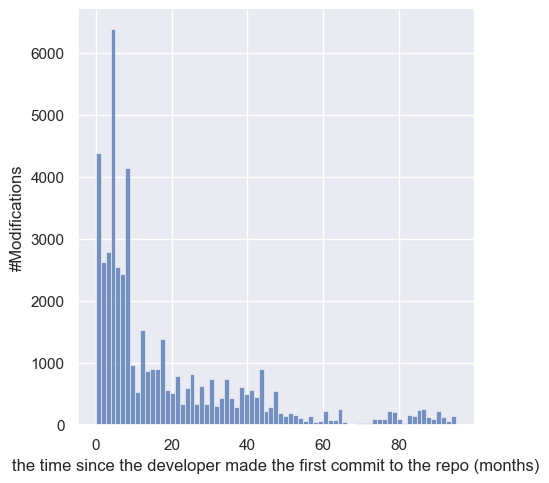

In [27]:
sns.displot(clean_df['contributing_months'])
plt.xlabel("the time since the developer made the first commit to the repo (months)")
plt.ylabel("#Modifications")
plt.show()

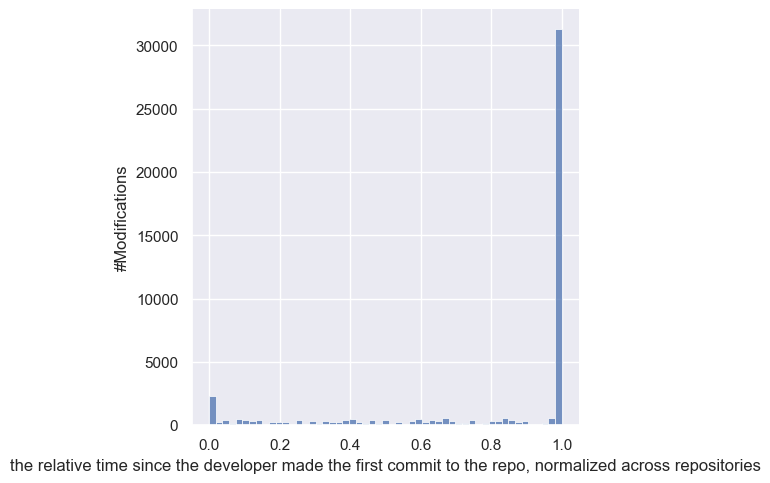

In [28]:
sns.displot(clean_df['contributing_months_relative_norm'])
plt.xlabel("the relative time since the developer made the first commit to the repo, normalized across repositories")
plt.ylabel("#Modifications")
plt.show()

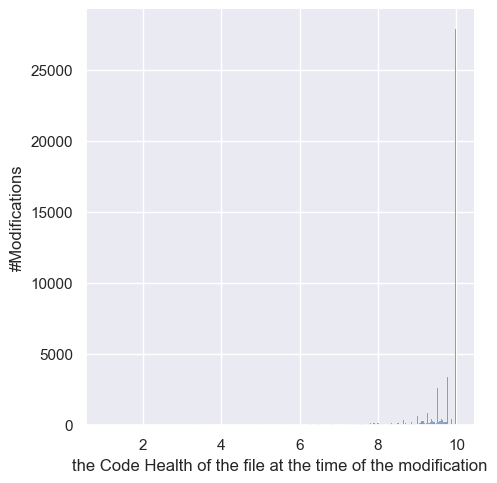

In [29]:
sns.displot(clean_df['code_health'])
plt.xlabel("the Code Health of the file at the time of the modification")
plt.ylabel("#Modifications")
plt.show()

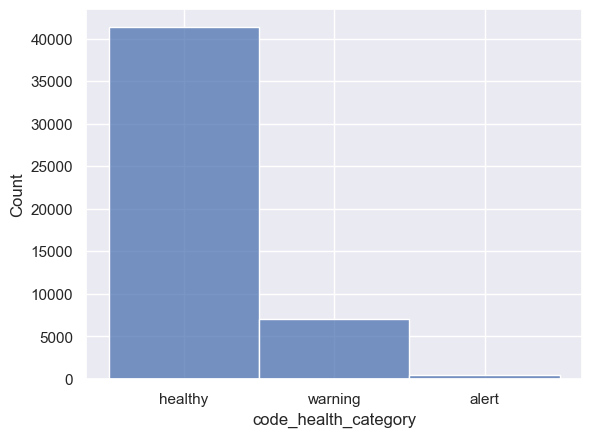

In [30]:
sns.histplot(x="code_health_category", data=clean_df)
plt.show()

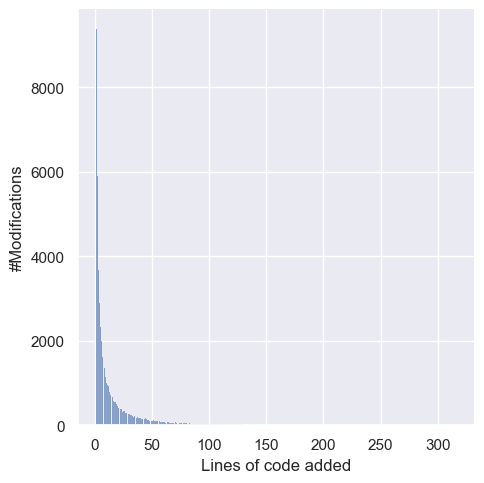

In [31]:
sns.displot(clean_df['added_loc'])
plt.xlabel("Lines of code added")
plt.ylabel("#Modifications")
plt.show()

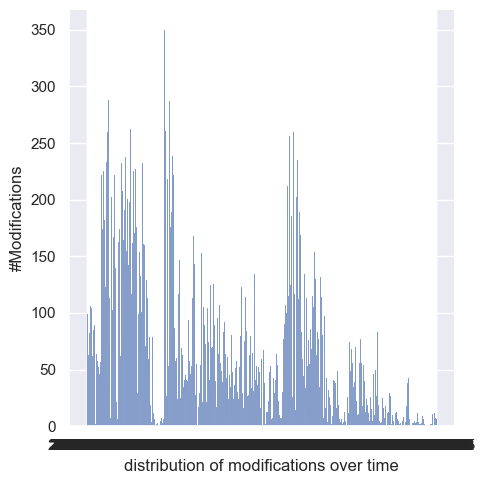

In [32]:
sns.displot(clean_df['date'])
plt.xlabel("distribution of modifications over time")
plt.ylabel("#Modifications")
plt.show()

We note the Covid-19 pandemic, resulting in the first gap from the left.

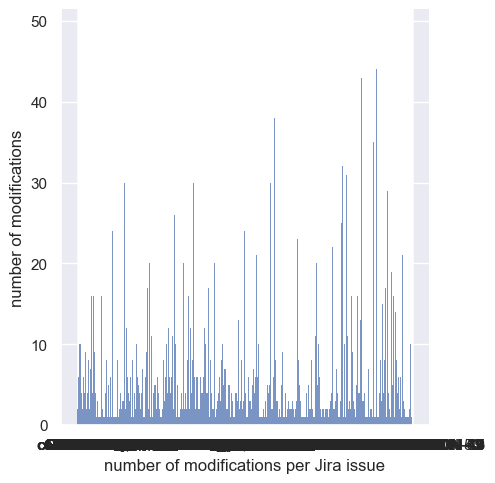

In [33]:
sns.displot(clean_df['ticket_id'])
plt.xlabel("number of modifications per Jira issue")
plt.ylabel("number of modifications")
plt.show()

## Data preprocessing

To meet the pre-conditions for later ANOVA, we must ensure normality of the dependent variable. We normalize time-in-development using the Yeo-Johnson algorithm. The scaled value can be used for plots and descriptive statistics.

In [34]:
clean_df = scale_and_normalize_df(clean_df, 'lead_time_minutes')

clean_df.describe()

,contributing_months_relative_norm,lead_time_minutes,module_ownership,contributing_months,added_loc,code_health,lead_time_minutes_scaled,lead_time_minutes_norm
count,48644.000000,48967.000000,48967.000000,48967.000000,48967.000000,48967.000000,48967.000000,4.896700e+04
mean,0.796697,2433.248923,0.436111,18.924398,18.050748,9.438160,0.239965,8.615741e-16
std,0.329896,2492.172491,0.377170,21.511982,34.192259,1.158567,0.245776,1.000010e+00
min,0.000000,60.000000,0.000000,0.000000,1.000000,1.000000,0.005917,-1.540639e+00
25%,0.650000,300.000000,0.074858,4.000000,2.000000,9.490000,0.029586,-8.970921e-01
50%,1.000000,1560.000000,0.319222,9.000000,6.000000,10.000000,0.153846,8.808488e-02
75%,1.000000,3720.000000,0.841379,28.000000,18.000000,10.000000,0.366864,7.908597e-01
max,1.000000,10140.000000,1.000000,95.000000,316.000000,10.000000,1.000000,1.810162e+00


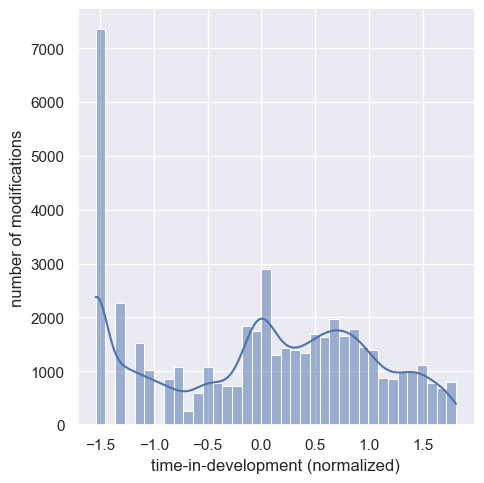

In [35]:
sns.displot(data=clean_df['lead_time_minutes_norm'], kde=True)
plt.xlabel("time-in-development (normalized)")
plt.ylabel("number of modifications")
plt.show()

## Split the data according to categorical variables
We will later measure the dependent variable for different subsets of the data.

In [36]:
# Group the data into code health categories
healthy_df = clean_df[clean_df['code_health_category']=='healthy']
warning_df = clean_df[clean_df['code_health_category']=='warning']
alert_df = clean_df[clean_df['code_health_category']=='alert']

In [37]:
# Group the data into ownership categories
marginal_df = clean_df[clean_df['author_ownership_category']=='marginal']
minor_df = clean_df[clean_df['author_ownership_category']=='minor']
major_df = clean_df[clean_df['author_ownership_category']=='major']
dominant_df = clean_df[clean_df['author_ownership_category']=='dominant']

In [38]:
# Group the data into change size categories
small_changes_df = clean_df[clean_df['added_loc_category']=='small']
medium_changes_df = clean_df[clean_df['added_loc_category']=='medium']
large_changes_df = clean_df[clean_df['added_loc_category']=='large']

In [39]:
# Split the data into (unplanned) bug fixes and (planned) feature implementation per code health category
bugs_df = clean_df[clean_df['bug_fix']==True]
features_df = clean_df[clean_df['bug_fix']==False]
bugs_healthy_df = healthy_df[healthy_df['bug_fix']==True]
features_healthy_df = healthy_df[healthy_df['bug_fix']==False]
bugs_warning_df = warning_df[warning_df['bug_fix']==True]
features_warning_df = warning_df[warning_df['bug_fix']==False]
bugs_alert_df = alert_df[alert_df['bug_fix']==True]
features_alert_df = alert_df[alert_df['bug_fix']==False]

In [40]:
# Group the data into ownership categories per code health
# Green code
healthy_marginal_df = healthy_df[healthy_df['author_ownership_category']=='marginal']
healthy_minor_df = healthy_df[healthy_df['author_ownership_category']=='minor']
healthy_major_df = healthy_df[healthy_df['author_ownership_category']=='major']
healthy_dominant_df = healthy_df[healthy_df['author_ownership_category']=='dominant']

# Yellow code
warning_marginal_df = warning_df[warning_df['author_ownership_category']=='marginal']
warning_minor_df = warning_df[warning_df['author_ownership_category']=='minor']
warning_major_df = warning_df[warning_df['author_ownership_category']=='major']
warning_dominant_df = warning_df[warning_df['author_ownership_category']=='dominant']

# Red code
alert_marginal_df = alert_df[alert_df['author_ownership_category']=='marginal']
alert_minor_df = alert_df[alert_df['author_ownership_category']=='minor']
alert_major_df = alert_df[alert_df['author_ownership_category']=='major']
alert_dominant_df = alert_df[alert_df['author_ownership_category']=='dominant']

In [41]:
# Group the data into change size categories per ownership category
# Small
small_marginal_df = marginal_df[marginal_df['added_loc_category']=='small']
small_minor_df = minor_df[minor_df['added_loc_category']=='small']
small_major_df = major_df[major_df['added_loc_category']=='small']
small_dominant_df = dominant_df[dominant_df['added_loc_category']=='small']

# Medium
medium_marginal_df = marginal_df[marginal_df['added_loc_category']=='medium']
medium_minor_df = minor_df[minor_df['added_loc_category']=='medium']
medium_major_df = major_df[major_df['added_loc_category']=='medium']
medium_dominant_df = dominant_df[dominant_df['added_loc_category']=='medium']

# Large
large_marginal_df = marginal_df[marginal_df['added_loc_category']=='large']
large_minor_df = minor_df[minor_df['added_loc_category']=='large']
large_major_df = major_df[major_df['added_loc_category']=='large']
large_dominant_df = dominant_df[dominant_df['added_loc_category']=='large']

In [42]:
# Group the marginal ownership data into change size categories per code health
# Green code
healthy_small_marginal_df = healthy_marginal_df[healthy_marginal_df['added_loc_category']=='small']
healthy_medium_marginal_df = healthy_marginal_df[healthy_marginal_df['added_loc_category']=='medium']
healthy_large_marginal_df = healthy_marginal_df[healthy_marginal_df['added_loc_category']=='large']

# Yellow code
warning_small_marginal_df = warning_marginal_df[warning_marginal_df['added_loc_category']=='small']
warning_medium_marginal_df = warning_marginal_df[warning_marginal_df['added_loc_category']=='medium']
warning_large_marginal_df = warning_marginal_df[warning_marginal_df['added_loc_category']=='large']

# Red code
alert_small_marginal_df = alert_marginal_df[alert_marginal_df['added_loc_category']=='small']
alert_medium_marginal_df = alert_marginal_df[alert_marginal_df['added_loc_category']=='medium']
alert_large_marginal_df = alert_marginal_df[alert_marginal_df['added_loc_category']=='large']

In [43]:
# Group the data for bug fixes by marginal owners per code health category
bugs_healthy_marginal_df = bugs_healthy_df[bugs_healthy_df['author_ownership_category']=='marginal']
bugs_warning_marginal_df = bugs_warning_df[bugs_warning_df['author_ownership_category']=='marginal']
bugs_alert_marginal_df = bugs_alert_df[bugs_alert_df['author_ownership_category']=='marginal']

In [44]:
# Group the data for feature implementation by marginal owners per ownership category
features_healthy_marginal_df = features_healthy_df[features_healthy_df['author_ownership_category']=='marginal']
features_warning_marginal_df = features_warning_df[features_warning_df['author_ownership_category']=='marginal']
features_alert_marginal_df = features_alert_df[features_alert_df['author_ownership_category']=='marginal']

In [45]:
# Group the data for small issue resolutions by marginal owners
features_small_marginal_df = small_marginal_df[small_marginal_df['bug_fix']==False]
bugs_small_marginal_df = small_marginal_df[small_marginal_df['bug_fix']==True]

In [46]:
# Group the data for small feature implementation by marginal owners by code health category
features_healthy_small_marginal_df = features_healthy_marginal_df[features_healthy_marginal_df['added_loc_category']=='small']
features_warning_small_marginal_df = features_warning_marginal_df[features_warning_marginal_df['added_loc_category']=='small']
features_alert_small_marginal_df = features_alert_marginal_df[features_alert_marginal_df['added_loc_category']=='small']

In [47]:
# Group the data for large feature implementation by marginal owners by code health category
features_healthy_large_marginal_df = features_healthy_marginal_df[features_healthy_marginal_df['added_loc_category']=='large']
features_warning_large_marginal_df = features_warning_marginal_df[features_warning_marginal_df['added_loc_category']=='large']
features_alert_large_marginal_df = features_alert_marginal_df[features_alert_marginal_df['added_loc_category']=='large']

In [48]:
# Group the data for small bug fixes by marginal owners by code health category
bugs_healthy_small_marginal_df = bugs_healthy_marginal_df[bugs_healthy_marginal_df['added_loc_category']=='small']
bugs_warning_small_marginal_df = bugs_warning_marginal_df[bugs_warning_marginal_df['added_loc_category']=='small']
bugs_alert_small_marginal_df = bugs_alert_marginal_df[bugs_alert_marginal_df['added_loc_category']=='small']

In [49]:
# Group the data for large bug fixes by marginal owners by code health category
bugs_healthy_large_marginal_df = bugs_healthy_marginal_df[bugs_healthy_marginal_df['added_loc_category']=='large']
bugs_warning_large_marginal_df = bugs_warning_marginal_df[bugs_warning_marginal_df['added_loc_category']=='large']
bugs_alert_large_marginal_df = bugs_alert_marginal_df[bugs_alert_marginal_df['added_loc_category']=='large']

# RQ1: How is ownership distributed across files? 

We already plotted this for all files - the U shape was evident. Let's see if different subsets show the same.

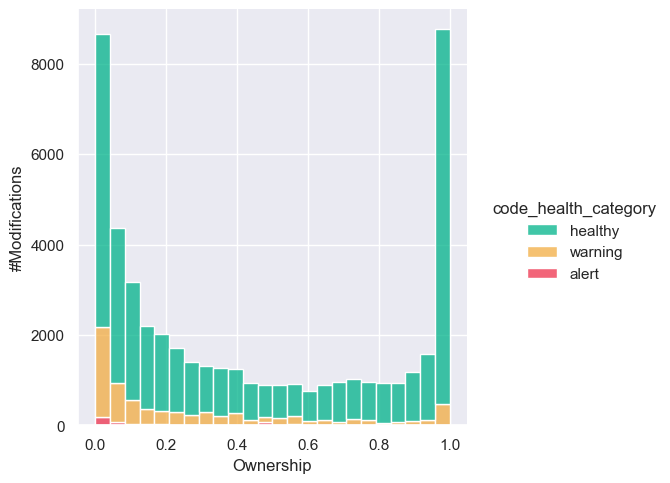

In [50]:
sns.displot(data=clean_df, x="module_ownership", hue="code_health_category", multiple="stack", palette=traffic_colors)
plt.xlabel("Ownership")
plt.ylabel("#Modifications")
plt.show()

There is a clear U-shape. Let's investigate what it looks like per Code Health category.

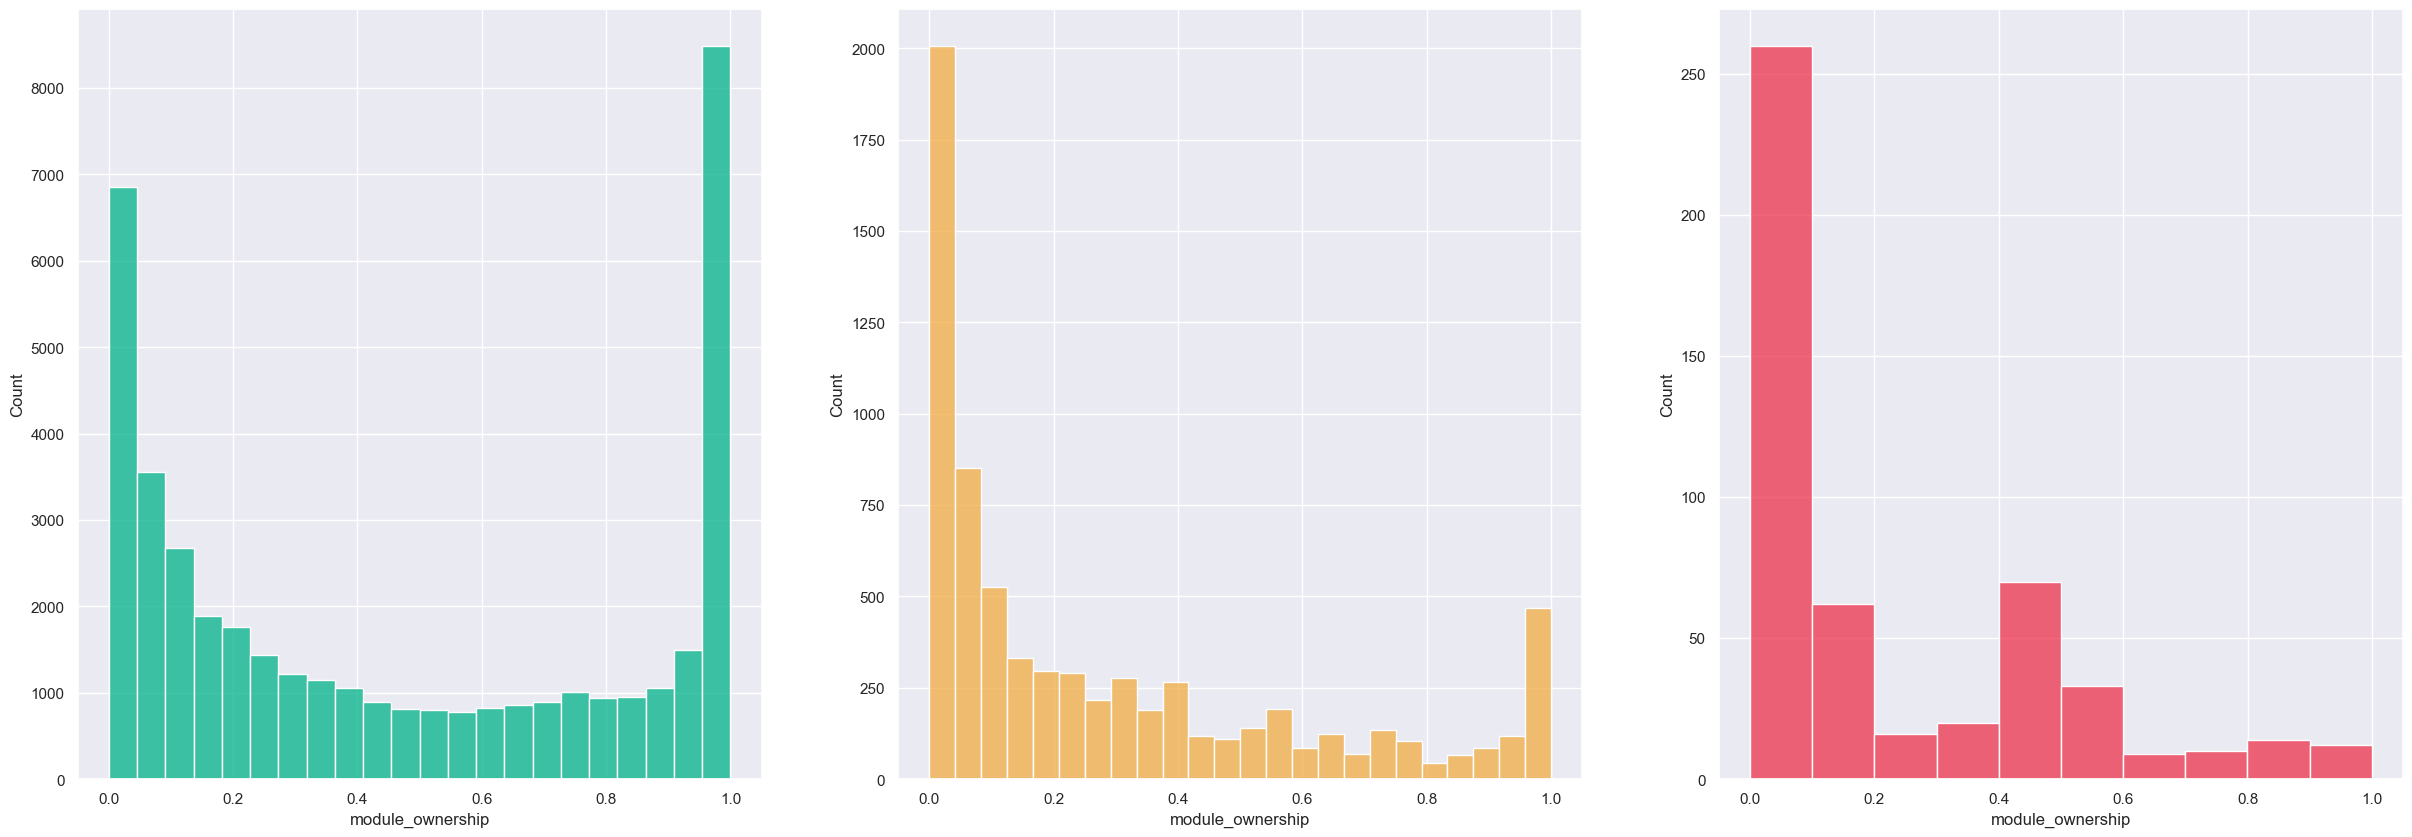

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

sns.histplot(ax=axes[0], data=healthy_df['module_ownership'], color=green_light)
sns.histplot(ax=axes[1], data=warning_df['module_ownership'], color=yellow_light)
sns.histplot(ax=axes[2], data=alert_df['module_ownership'], color=red_light)

plt.show()

## Conclusion

U owns the code that changes. Most changes target files with either a marginal or dominant owner. Most
changes to files with low-quality source code are made by developers with low levels of ownership.

# RQ2: How does a developer's project experience influence issue resolution times?  

Now we consider the "time since the first commit to the project" as a proxy for developer experience. We investigate whether this influences the time to resolve issues.

## Developer experience vs. time-in-development

First, we plot the time since the first commit to the project vs. the time-in-development for all data. We use the relative value for the time since the first commit to enable cross-project analysis.

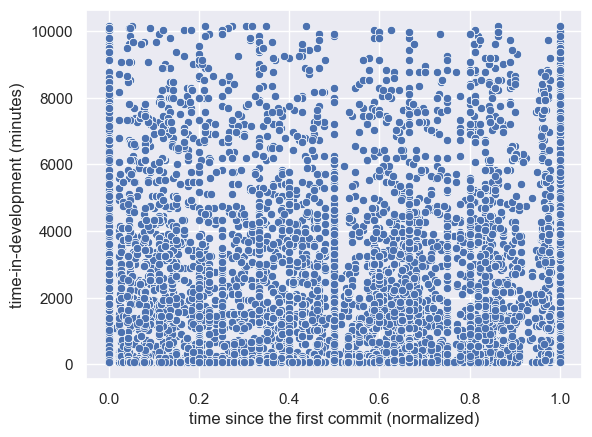

In [52]:
sns.scatterplot(data=clean_df, x="contributing_months_relative_norm", y="lead_time_minutes", palette="Blues_d")
plt.xlabel("time since the first commit (normalized)")
plt.ylabel("time-in-development (minutes)")
plt.show()

Investigating Spearman correlations for different subsets of the data.

In [53]:
spearman_corr = pg.corr(x=clean_df['contributing_months_relative_norm'], y=clean_df['lead_time_minutes'], method='spearman')
print("Spearman correlations:\nAll data: " + str(spearman_corr) +"\n")

spearman_corr_healthy = pg.corr(healthy_df['contributing_months_relative_norm'], healthy_df['lead_time_minutes'], method='spearman')
spearman_corr_warning = pg.corr(warning_df['contributing_months_relative_norm'], warning_df['lead_time_minutes'], method='spearman')
spearman_corr_alert = pg.corr(alert_df['contributing_months_relative_norm'], alert_df['lead_time_minutes'], method='spearman')
print("Healthy code: " + str(spearman_corr_healthy))
print("Warning code: " + str(spearman_corr_warning))
print("Alert code: " + str(spearman_corr_alert) + "\n")

spearman_corr_marginal = pg.corr(marginal_df['contributing_months_relative_norm'], marginal_df['lead_time_minutes'], method='spearman')
spearman_corr_minor = pg.corr(minor_df['contributing_months_relative_norm'], minor_df['lead_time_minutes'], method='spearman')
spearman_corr_major = pg.corr(major_df['contributing_months_relative_norm'], major_df['lead_time_minutes'], method='spearman')
spearman_corr_dominant = pg.corr(dominant_df['contributing_months_relative_norm'], dominant_df['lead_time_minutes'], method='spearman')
print("Marginal owners: " + str(spearman_corr_marginal))
print("Minor owners: " + str(spearman_corr_minor))
print("Major owners: " + str(spearman_corr_major))
print("Dominant owners: " + str(spearman_corr_dominant) + "\n")

spearman_corr_small = pg.corr(small_changes_df['contributing_months_relative_norm'], small_changes_df['lead_time_minutes'], method='spearman')
spearman_corr_medium = pg.corr(medium_changes_df['contributing_months_relative_norm'], medium_changes_df['lead_time_minutes'], method='spearman')
spearman_corr_large = pg.corr(large_changes_df['contributing_months_relative_norm'], large_changes_df['lead_time_minutes'], method='spearman')
print("Small changes: " + str(spearman_corr_small))
print("Medium changes: " + str(spearman_corr_medium))
print("Large changes: " + str(spearman_corr_large) + "\n")

spearman_corr_bugs = pg.corr(bugs_df['contributing_months_relative_norm'], bugs_df['lead_time_minutes'], method='spearman')
spearman_corr_features = pg.corr(features_df['contributing_months_relative_norm'], features_df['lead_time_minutes'], method='spearman')
print("Bug fixes: " + str(spearman_corr_bugs))
print("Feature implementation: " + str(spearman_corr_features) + "\n")

spearman_corr_healthy_bugs = pg.corr(bugs_healthy_df['contributing_months_relative_norm'], bugs_healthy_df['lead_time_minutes'], method='spearman')
spearman_corr_warning_bugs = pg.corr(bugs_warning_df['contributing_months_relative_norm'], bugs_warning_df['lead_time_minutes'], method='spearman')
spearman_corr_alert_bugs = pg.corr(bugs_alert_df['contributing_months_relative_norm'], bugs_alert_df['lead_time_minutes'], method='spearman')
print("Bug fixes in healthy code: " + str(spearman_corr_healthy_bugs))
print("Bug fixes in warning code: " + str(spearman_corr_warning_bugs))
print("Bug fixes in alert code: " + str(spearman_corr_alert_bugs) + "\n")

spearman_corr_healthy_bugs_marginal = pg.corr(bugs_healthy_marginal_df['contributing_months_relative_norm'], bugs_healthy_marginal_df['lead_time_minutes'], method='spearman')
print("Bug fixes in healthy code by marginal owners: " + str(spearman_corr_healthy_bugs_marginal))
spearman_corr_warning_bugs_marginal = pg.corr(bugs_warning_marginal_df['contributing_months_relative_norm'], bugs_warning_marginal_df['lead_time_minutes'], method='spearman')
print("Bug fixes in warning code by marginal owners: " + str(spearman_corr_warning_bugs_marginal))
spearman_corr_alert_bugs_marginal = pg.corr(bugs_alert_marginal_df['contributing_months_relative_norm'], bugs_alert_marginal_df['lead_time_minutes'], method='spearman')
print("Bug fixes in alert code by marginal owners: " + str(spearman_corr_alert_bugs_marginal))

Pearson correlations:
All data:              n         r          CI95%         p-val       BF10  power
pearson  48644 -0.093475  [-0.1, -0.08]  7.788676e-95  2.793e+90    1.0

Healthy code:              n         r          CI95%         p-val       BF10  power
pearson  41098 -0.093149  [-0.1, -0.08]  7.188349e-80  3.592e+75    1.0
Warning code:             n        r           CI95%         p-val       BF10  power
pearson  7047 -0.09182  [-0.11, -0.07]  1.137322e-14  1.326e+11    1.0
Alert code:            n         r           CI95%     p-val   BF10     power
pearson  499 -0.139172  [-0.22, -0.05]  0.001832  7.099  0.877511

Marginal owners:              n         r           CI95%         p-val       BF10  power
pearson  14115 -0.134974  [-0.15, -0.12]  2.234648e-58  2.297e+54    1.0
Minor owners:              n         r           CI95%         p-val       BF10  power
pearson  14860 -0.106224  [-0.12, -0.09]  1.496604e-38  4.161e+34    1.0
Major owners:             n         r    

There are at most weak correlations in the data.

## Investigating why more experienced developers are not resolving issues faster

An important confounding factor is the difficulty of the issues. We rely on the size of the resolutions as a proxy for its difficulty. Does this make sense? Does time-in-development correlate with the added lines of code? 

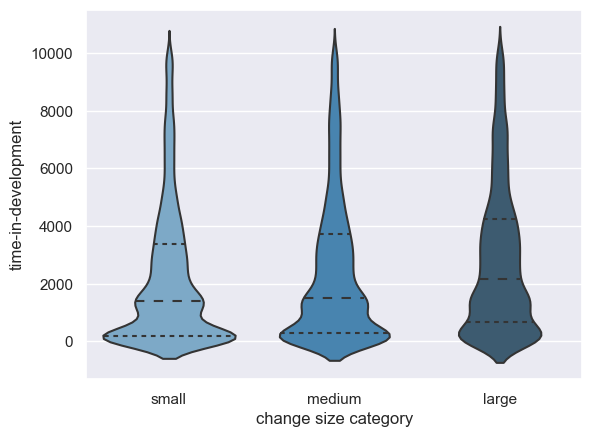

In [54]:
#title='Time-in-development by change size'
bx = sns.violinplot(x='added_loc_category', y='lead_time_minutes', data=clean_df, order=['small', 'medium', 'large'], inner="quart", palette="Blues_d")
bx.set(xlabel='change size category', ylabel='time-in-development')
plt.show(bx)

There appears to be a difference, many small changes are really fast. Some large changes take longer time. Let's check the correlations.

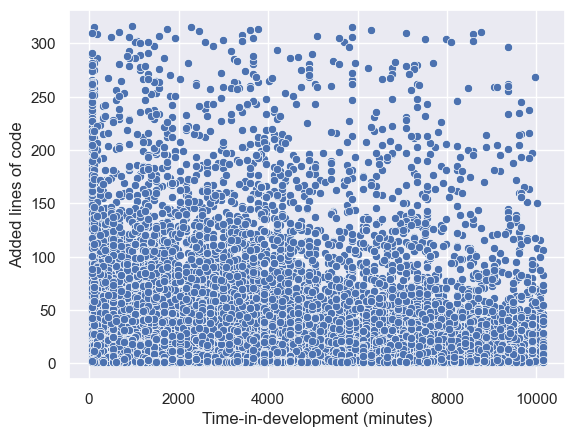

In [55]:
sns.scatterplot(data=clean_df, x="lead_time_minutes", y="added_loc", palette="Blues_d")
plt.xlabel("Time-in-development (minutes)")
plt.ylabel("Added lines of code")
plt.show()

In [70]:
spearman_corr = pg.corr(clean_df['lead_time_minutes'], clean_df['added_loc'], method="spearman")
print("Spearman correlations:\nAll data: " + str(spearman_corr) +"\n")

spearman_corr_healthy = pg.corr(healthy_df['lead_time_minutes'], healthy_df['added_loc'], method="spearman")
spearman_corr_warning = pg.corr(warning_df['lead_time_minutes'], warning_df['added_loc'], method="spearman")
spearman_corr_alert = pg.corr(alert_df['lead_time_minutes'], alert_df['added_loc'], method="spearman")
print("Healthy code: " + str(spearman_corr_healthy))
print("Warning code: " + str(spearman_corr_warning))
print("Alert code: " + str(spearman_corr_alert) + "\n")

spearman_corr_marginal = pg.corr(marginal_df['lead_time_minutes'], marginal_df['added_loc'], method="spearman")
spearman_corr_minor = pg.corr(minor_df['lead_time_minutes'], minor_df['added_loc'], method="spearman")
spearman_corr_major = pg.corr(major_df['lead_time_minutes'], major_df['added_loc'], method="spearman")
spearman_corr_dominant = pg.corr(dominant_df['lead_time_minutes'], dominant_df['added_loc'], method="spearman")
print("Marginal owners: " + str(spearman_corr_marginal))
print("Minor owners: " + str(spearman_corr_minor))
print("Major owners: " + str(spearman_corr_major))
print("Dominant owners: " + str(spearman_corr_dominant) + "\n")

spearman_corr_small = pg.corr(small_changes_df['lead_time_minutes'], small_changes_df['added_loc'], method="spearman")
spearman_corr_medium = pg.corr(medium_changes_df['lead_time_minutes'], medium_changes_df['added_loc'], method="spearman")
spearman_corr_large = pg.corr(large_changes_df['lead_time_minutes'], large_changes_df['added_loc'], method="spearman")
print("Small changes: " + str(spearman_corr_small))
print("Medium changes: " + str(spearman_corr_medium))
print("Large changes: " + str(spearman_corr_large) + "\n")

spearman_corr_bugs = pg.corr(bugs_df['lead_time_minutes'], bugs_df['added_loc'], method="spearman")
spearman_corr_features = pg.corr(features_df['lead_time_minutes'], features_df['added_loc'], method="spearman")
print("Bug fixes: " + str(spearman_corr_bugs))
print("Feature implementation: " + str(spearman_corr_features) + "\n")

spearman_corr_healthy_bugs = pg.corr(bugs_healthy_df['lead_time_minutes'], bugs_healthy_df['added_loc'], method="spearman")
spearman_corr_warning_bugs = pg.corr(bugs_warning_df['lead_time_minutes'], bugs_warning_df['added_loc'], method="spearman")
spearman_corr_alert_bugs = pg.corr(bugs_alert_df['lead_time_minutes'], bugs_alert_df['added_loc'], method="spearman")
print("Bug fixes in healthy code: " + str(spearman_corr_healthy_bugs))
print("Bug fixes in warning code: " + str(spearman_corr_warning_bugs))
print("Bug fixes in alert code: " + str(spearman_corr_alert_bugs) + "\n")

spearman_corr_healthy_bugs_marginal = pg.corr(bugs_healthy_marginal_df['lead_time_minutes'], bugs_healthy_marginal_df['added_loc'], method="spearman")
print("Bug fixes in healthy code by marginal owners: " + str(spearman_corr_healthy_bugs_marginal))
spearman_corr_warning_bugs_marginal = pg.corr(bugs_warning_marginal_df['lead_time_minutes'], bugs_warning_marginal_df['added_loc'], method="spearman")
print("Bug fixes in warning code by marginal owners: " + str(spearman_corr_warning_bugs_marginal))
spearman_corr_alert_bugs_marginal = pg.corr(bugs_alert_marginal_df['lead_time_minutes'], bugs_alert_marginal_df['added_loc'], method="spearman")
print("Bug fixes in alert code by marginal owners: " + str(spearman_corr_alert_bugs_marginal))

Spearman correlations:
All data:               n         r        CI95%          p-val  power
spearman  48967  0.109806  [0.1, 0.12]  3.420465e-131    1.0

Healthy code:               n         r        CI95%          p-val  power
spearman  41361  0.112482  [0.1, 0.12]  1.540356e-116    1.0
Warning code:              n         r         CI95%         p-val  power
spearman  7100  0.097648  [0.07, 0.12]  1.634510e-16    1.0
Alert code:             n         r          CI95%    p-val    power
spearman  506  0.064114  [-0.02, 0.15]  0.14983  0.30225

Marginal owners:               n         r        CI95%         p-val  power
spearman  14266  0.084867  [0.07, 0.1]  3.183033e-24    1.0
Minor owners:               n         r        CI95%         p-val  power
spearman  14920  0.113365  [0.1, 0.13]  7.195062e-44    1.0
Major owners:              n         r         CI95%         p-val  power
spearman  8872  0.092355  [0.07, 0.11]  2.871796e-18    1.0
Dominant owners:               n         r

We mostly find positive rather than negative correlations, i.e., the developers that have been around for a long time resolve issues that require more time-in-development.

But do we find any indications in the data that seasoned developers are assigned the more difficult issues?

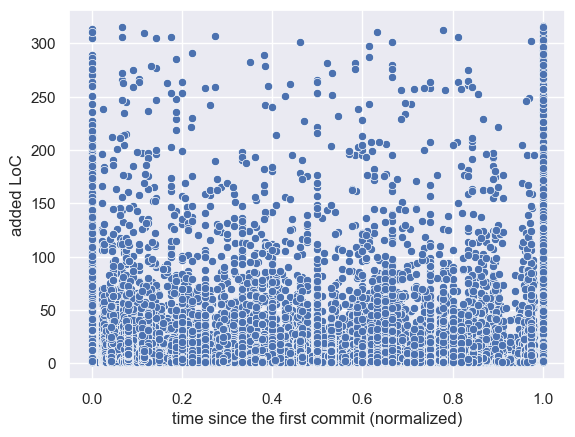

In [57]:
sns.scatterplot(data=clean_df, x="contributing_months_relative_norm", y="added_loc")
plt.xlabel("time since the first commit (normalized)")
plt.ylabel("added LoC")
plt.show()

In [71]:
spearman_corr = pg.corr(clean_df['contributing_months_relative_norm'], clean_df['added_loc'], method="spearman")
print("Spearman correlations:\nAll data: " + str(spearman_corr) +"\n")

spearman_corr_healthy = pg.corr(healthy_df['contributing_months_relative_norm'], healthy_df['added_loc'], method="spearman")
spearman_corr_warning = pg.corr(warning_df['contributing_months_relative_norm'], warning_df['added_loc'], method="spearman")
spearman_corr_alert = pg.corr(alert_df['contributing_months_relative_norm'], alert_df['added_loc'], method="spearman")
print("Healthy code: " + str(spearman_corr_healthy))
print("Warning code: " + str(spearman_corr_warning))
print("Alert code: " + str(spearman_corr_alert) + "\n")

spearman_corr_marginal = pg.corr(marginal_df['contributing_months_relative_norm'], marginal_df['added_loc'], method="spearman")
spearman_corr_minor = pg.corr(minor_df['contributing_months_relative_norm'], minor_df['added_loc'], method="spearman")
spearman_corr_major = pg.corr(major_df['contributing_months_relative_norm'], major_df['added_loc'], method="spearman")
spearman_corr_dominant = pg.corr(dominant_df['contributing_months_relative_norm'], dominant_df['added_loc'], method="spearman")
print("Marginal owners: " + str(spearman_corr_marginal))
print("Minor owners: " + str(spearman_corr_minor))
print("Major owners: " + str(spearman_corr_major))
print("Dominant owners: " + str(spearman_corr_dominant) + "\n")

spearman_corr_small = pg.corr(small_changes_df['contributing_months_relative_norm'], small_changes_df['added_loc'], method="spearman")
spearman_corr_medium = pg.corr(medium_changes_df['contributing_months_relative_norm'], medium_changes_df['added_loc'], method="spearman")
spearman_corr_large = pg.corr(large_changes_df['contributing_months_relative_norm'], large_changes_df['added_loc'], method="spearman")
print("Small changes: " + str(spearman_corr_small))
print("Medium changes: " + str(spearman_corr_medium))
print("Large changes: " + str(spearman_corr_large) + "\n")

spearman_corr_bugs = pg.corr(bugs_df['contributing_months_relative_norm'], bugs_df['added_loc'], method="spearman")
spearman_corr_features = pg.corr(features_df['contributing_months_relative_norm'], features_df['added_loc'], method="spearman")
print("Bug fixes: " + str(spearman_corr_bugs))
print("Feature implementation: " + str(spearman_corr_features) + "\n")

spearman_corr_healthy_bugs = pg.corr(bugs_healthy_df['contributing_months_relative_norm'], bugs_healthy_df['added_loc'], method="spearman")
spearman_corr_warning_bugs = pg.corr(bugs_warning_df['contributing_months_relative_norm'], bugs_warning_df['added_loc'], method="spearman")
spearman_corr_alert_bugs = pg.corr(bugs_alert_df['contributing_months_relative_norm'], bugs_alert_df['added_loc'], method="spearman")
print("Bug fixes in healthy code: " + str(spearman_corr_healthy_bugs))
print("Bug fixes in warning code: " + str(spearman_corr_warning_bugs))
print("Bug fixes in alert code: " + str(spearman_corr_alert_bugs) + "\n")

spearman_corr_healthy_bugs_marginal = pg.corr(bugs_healthy_marginal_df['contributing_months_relative_norm'], bugs_healthy_marginal_df['added_loc'], method="spearman")
print("Bug fixes in healthy code by marginal owners: " + str(spearman_corr_healthy_bugs_marginal))
spearman_corr_warning_bugs_marginal = pg.corr(bugs_warning_marginal_df['contributing_months_relative_norm'], bugs_warning_marginal_df['added_loc'], method="spearman")
print("Bug fixes in warning code by marginal owners: " + str(spearman_corr_warning_bugs_marginal))
spearman_corr_alert_bugs_marginal = pg.corr(bugs_alert_marginal_df['contributing_months_relative_norm'], bugs_alert_marginal_df['added_loc'], method="spearman")
print("Bug fixes in alert code by marginal owners: " + str(spearman_corr_alert_bugs_marginal))

Spearman correlations:
All data:               n        r           CI95%         p-val  power
spearman  48644 -0.03896  [-0.05, -0.03]  8.266183e-18    1.0

Healthy code:               n        r           CI95%         p-val  power
spearman  41098 -0.03405  [-0.04, -0.02]  5.031084e-12    1.0
Warning code:              n         r           CI95%         p-val     power
spearman  7047 -0.063919  [-0.09, -0.04]  7.859881e-08  0.999678
Alert code:             n         r           CI95%     p-val     power
spearman  499 -0.106658  [-0.19, -0.02]  0.017154  0.665176

Marginal owners:               n       r           CI95%     p-val     power
spearman  14115 -0.0232  [-0.04, -0.01]  0.005843  0.787175
Minor owners:               n         r           CI95%         p-val  power
spearman  14860 -0.064339  [-0.08, -0.05]  4.142491e-15    1.0
Major owners:              n         r           CI95%         p-val  power
spearman  8799 -0.101395  [-0.12, -0.08]  1.508013e-21    1.0
Dominant own

No, we find no correlations here.

Could it be that experienced developers tend to work in the more difficult low-quality source code files?

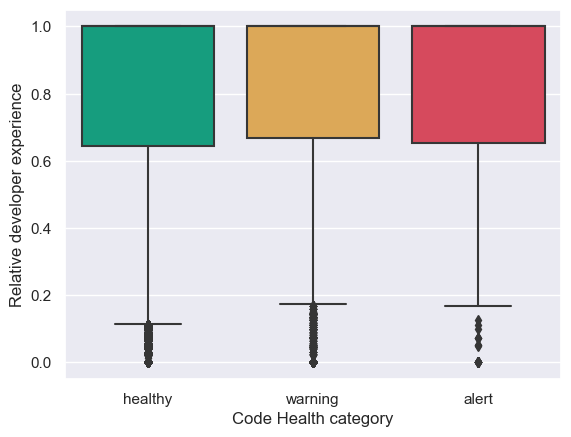

In [59]:
#title='Experience by Code Health category'
bx = sns.boxplot(x="code_health_category", y='contributing_months_relative_norm', data=clean_df, order=['healthy', 'warning', 'alert'], palette=traffic_colors)
bx.set(xlabel='Code Health category', ylabel='Relative developer experience')
plt.show(bx)

No, there are no apparent differences between the groups. Nothing in our data can explain why developer experience is not correlated with issue resolution times. Software engineering is complex, we have not identified the confounding variables at play.

## Conclusion

We find no relationship between developer experience and issue resolution times. Neither change size nor source
code quality can explain the absence of the relationship.

# RQ3: How does code quality influence issue resolution times for developers with low file-level ownership?

We assume that ownership influences issue resolution times more than experience.

We estimate ownership as the fraction of commits a developer made to a specific file. Does a high level of ownership suggest a shorter time-in-development?

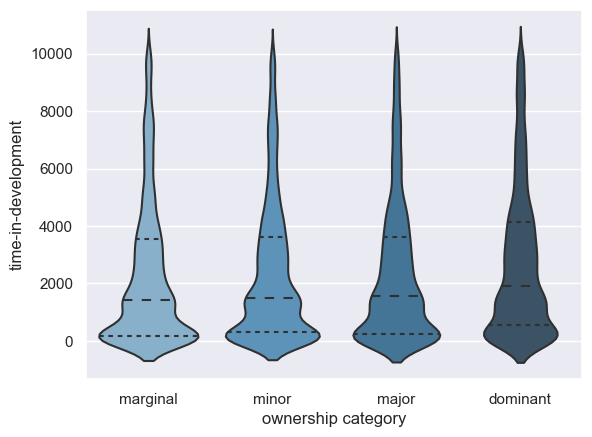

Medians: 1440.0 - 1500.0 - 1560.0 - 1920.0


In [60]:
#title='Time-in-Development by ownership'
bx = sns.violinplot(x='author_ownership_category', y='lead_time_minutes', data=clean_df, order=['marginal', 'minor', 'major', 'dominant'], inner="quartile", palette="Blues_d")
bx.set(xlabel='ownership category', ylabel='time-in-development')
plt.show(bx)

median_clean_marg = marginal_df['lead_time_minutes'].median()
median_clean_min = minor_df['lead_time_minutes'].median()
median_clean_maj = major_df['lead_time_minutes'].median()
median_clean_dom = dominant_df['lead_time_minutes'].median()

print("Medians: " + str(median_clean_marg) + " - " + str(median_clean_min) + " - " + str(median_clean_maj) + " - " + str(median_clean_dom))

No, the opposite can be seen in the data. Dominant owners are related to modifications with longer time-in-development.

## Relationship between added time-in-development and ownership for green/yellow/red code
We hypothesize that the differences will be amplified in low-quality source code for developers with low ownership. If our hypothesis is supported, then we expect the difference in time-in-development to increase in yellow/red code. Developers with marginal and minor ownership would then need even more time relative to the major and dominant developers.

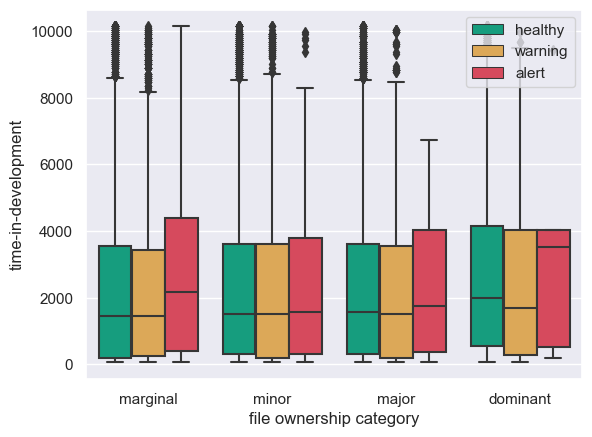

Medians marginal owners: 1440.0 - 1440.0 - 2160.0
Medians minor owners: 1500.0 - 1500.0 - 1560.0
Medians major owners: 1560.0 - 1500.0 - 1740.0
Medians dominant owners: 1980.0 - 1680.0 - 3510.0
Note that there are only 12 dominant owners in red code.


In [61]:
#title='Time-in-development by ownership'
bx = sns.boxplot(x='author_ownership_category', y='lead_time_minutes', hue="code_health_category", data=clean_df, order=['marginal', 'minor', 'major', 'dominant'], palette=traffic_colors)
bx.set(xlabel='file ownership category', ylabel='time-in-development')
plt.legend(loc='upper right')
plt.show(bx)

median_healthy_marg = healthy_marginal_df['lead_time_minutes'].median()
median_warning_marg = warning_marginal_df['lead_time_minutes'].median()
median_alert_marg = alert_marginal_df['lead_time_minutes'].median()
median_healthy_min = healthy_minor_df['lead_time_minutes'].median()
median_warning_min = warning_minor_df['lead_time_minutes'].median()
median_alert_min = alert_minor_df['lead_time_minutes'].median()
median_healthy_maj = healthy_major_df['lead_time_minutes'].median()
median_warning_maj = warning_major_df['lead_time_minutes'].median()
median_alert_maj = alert_major_df['lead_time_minutes'].median()
median_healthy_dom = healthy_dominant_df['lead_time_minutes'].median()
median_warning_dom = warning_dominant_df['lead_time_minutes'].median()
median_alert_dom = alert_dominant_df['lead_time_minutes'].median()

print("Medians marginal owners: " + str(median_healthy_marg) + " - " + str(median_warning_marg) + " - " + str(median_alert_marg))
print("Medians minor owners: " + str(median_healthy_min) + " - " + str(median_warning_min) + " - " + str(median_alert_min))
print("Medians major owners: " + str(median_healthy_maj) + " - " + str(median_warning_maj) + " - " + str(median_alert_maj))
print("Medians dominant owners: " + str(median_healthy_dom) + " - " + str(median_warning_dom) + " - " + str(median_alert_dom))
print("Note that there are only " + str(len(alert_dominant_df)) + " dominant owners in red code.")

There are three assumptions for running ANOVA tests.
1. Randomness and independence: this is typically violoated when mining software repositories.
1. Normality: we already normalized the dependent variable.
1. Homoscedasticity (homogeneity of variances): we check this using Levene's test below.

In [62]:
# Levene's Test using Pingouin
pg.homoscedasticity(marginal_df, dv='lead_time_minutes_norm', group='code_health_category')

,W,pval,equal_var
levene,1.489,0.225633,True


We consider the assumptions fulfilled and continue with the ANOVA test.

In [63]:
import pingouin as pg

# h0_1
aov_marg = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=marginal_df, detailed='True')
pg.print_table(aov_marg)

# h0_2
aov_minor = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=minor_df, detailed='True')
pg.print_table(aov_minor)

# h0_3
aov_major = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=major_df, detailed='True')
pg.print_table(aov_major)

# h0_4
aov_dom = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=dominant_df, detailed='True')
pg.print_table(aov_dom)


ANOVA SUMMARY

Source                       SS     DF     MS        F    p-unc      np2
--------------------  ---------  -----  -----  -------  -------  -------
code_health_category     12.100      2  6.050    5.785    0.003    0.001
Within                14916.895  14263  1.046  nan      nan      nan


ANOVA SUMMARY

Source                       SS     DF     MS        F    p-unc      np2
--------------------  ---------  -----  -----  -------  -------  -------
code_health_category      1.847      2  0.924    0.945    0.389    0.000
Within                14575.748  14917  0.977  nan      nan      nan


ANOVA SUMMARY

Source                      SS    DF     MS        F    p-unc      np2
--------------------  --------  ----  -----  -------  -------  -------
code_health_category     5.564     2  2.782    2.815    0.060    0.001
Within                8763.129  8869  0.988  nan      nan      nan


ANOVA SUMMARY

Source                       SS     DF     MS        F    p-unc      np2
----

We reject h1 and h4. In this study we focus on marginal owners. We continue analyzing the former subset and perform one-way ANOVA tests using blocking, i.e., we consider different change sizes separately.

## Analysis of marginal owners

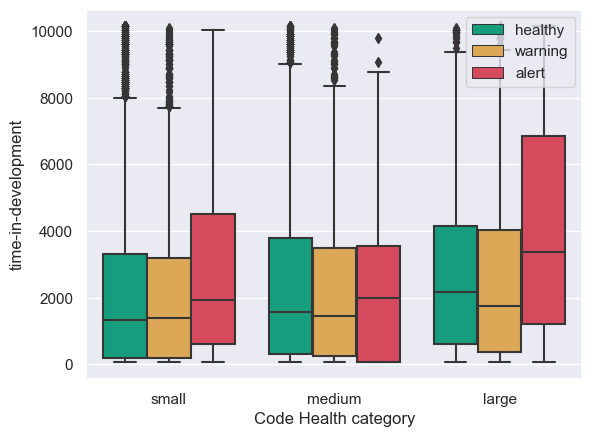

Medians marginal owners for small changes: 1320.0 - 1380.0 - 1920.0
Medians marginal owners for medium changes: 1560.0 - 1440.0 - 1980.0
Medians marginal owners for large changes: 2160.0 - 1740.0 - 3360.0


In [64]:
bx = sns.boxplot(x='added_loc_category', y='lead_time_minutes', hue="code_health_category", data=marginal_df, order=['small', 'medium', 'large'], palette=traffic_colors)
#bx.set(xlabel='Code Health category', ylabel='time-in-development', title='Time-in-development for modifications by marginal owners by code health and change size')
bx.set(xlabel='Code Health category', ylabel='time-in-development')
plt.legend(loc='upper right')
plt.show(bx)

median_healthy_small_marg = healthy_small_marginal_df['lead_time_minutes'].median()
median_warning_small_marg = warning_small_marginal_df['lead_time_minutes'].median()
median_alert_small_marg = alert_small_marginal_df['lead_time_minutes'].median()
median_healthy_medium_marg = healthy_medium_marginal_df['lead_time_minutes'].median()
median_warning_medium_marg = warning_medium_marginal_df['lead_time_minutes'].median()
median_alert_medium_marg = alert_medium_marginal_df['lead_time_minutes'].median()
median_healthy_large_marg = healthy_large_marginal_df['lead_time_minutes'].median()
median_warning_large_marg = warning_large_marginal_df['lead_time_minutes'].median()
median_alert_large_marg = alert_large_marginal_df['lead_time_minutes'].median()

print("Medians marginal owners for small changes: " + str(median_healthy_small_marg) + " - " + str(median_warning_small_marg) + " - " + str(median_alert_small_marg))
print("Medians marginal owners for medium changes: " + str(median_healthy_medium_marg) + " - " + str(median_warning_medium_marg) + " - " + str(median_alert_medium_marg))
print("Medians marginal owners for large changes: " + str(median_healthy_large_marg) + " - " + str(median_warning_large_marg) + " - " + str(median_alert_large_marg))


### Small changes
We pose the null hypothesis:
- h0_1_s = The distributions for red/yellow/green code for marginal authors making small changes are the same.


In [65]:
aov_small = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=small_marginal_df, detailed='True')
pg.print_table(aov_small)


ANOVA SUMMARY

Source                      SS    DF     MS        F    p-unc      np2
--------------------  --------  ----  -----  -------  -------  -------
code_health_category    11.931     2  5.965    5.748    0.003    0.001
Within                8999.331  8672  1.038  nan      nan      nan



We reject h0_1_s.

There are statistically significant differences between red/yellow/green code for small changes by marginal owners. Let's do a pairwise Tukey-HSD posthoc test.

In [66]:
tukey = pg.pairwise_tukey(data=small_marginal_df, dv='lead_time_minutes_norm', between='code_health_category')
print(tukey)

difference = median_alert_small_marg - median_healthy_small_marg
increase = difference / median_healthy_small_marg 
print("\nThe overall difference between red and green code: +" + str(increase*100) +"%")

diff_features = features_alert_small_marginal_df['lead_time_minutes'].median() - features_healthy_small_marginal_df['lead_time_minutes'].median()
increase_features = diff_features / features_healthy_small_marginal_df['lead_time_minutes'].median()
print("(Only feature implementation: +" + str(increase_features*100) +"%)")

diff_bugs = bugs_alert_small_marginal_df['lead_time_minutes'].median() - bugs_healthy_small_marginal_df['lead_time_minutes'].median()
increase_bugs = diff_bugs / bugs_healthy_small_marginal_df['lead_time_minutes'].median()
print("(Only bug fizes: +" + str(increase_bugs*100) +"%)")

difference2 = median_alert_small_marg - median_warning_small_marg
increase2 = difference2 / median_warning_small_marg 
print("\nThe overall difference between red and yellow code: +" + str(increase2*100) +"%")

diff_features2 = features_alert_small_marginal_df['lead_time_minutes'].median() - features_warning_small_marginal_df['lead_time_minutes'].median()
increase_features2 = diff_features2 / features_warning_small_marginal_df['lead_time_minutes'].median()
print("(Only feature implementation: +" + str(increase_features2*100) +"%)")

diff_bugs2 = bugs_alert_small_marginal_df['lead_time_minutes'].median() - bugs_warning_small_marginal_df['lead_time_minutes'].median()
increase_bugs2 = diff_bugs2 / bugs_warning_small_marginal_df['lead_time_minutes'].median()
print("(Only bug fizes: +" + str(increase_bugs2*100) +"%)")

         A        B   mean(A)   mean(B)      diff        se         T  \
0    alert  healthy  0.157852 -0.148792  0.306644  0.094175  3.256104   
1    alert  warning  0.157852 -0.116737  0.274589  0.096876  2.834442   
2  healthy  warning -0.148792 -0.116737 -0.032055  0.028509 -1.124381   

    p-tukey    hedges  
0  0.003252  0.300983  
1  0.012780  0.269428  
2  0.499015 -0.031464  

The overall difference between red and green code: +45.45454545454545%
(Only feature implementation: +95.65217391304348%)
(Only bug fizes: +58.82352941176471%)

The overall difference between red and yellow code: +39.130434782608695%
(Only feature implementation: +87.5%)
(Only bug fizes: +50.0%)


Issue resolution times are significantly different (with a small effect size) when marginal owners make small changes in healthy vs. alert code. Compared to green code, the median time that marginal owners need time to make small changes in red code is 45% longer.

Issue resolution times are significantly different (with a small effect size) when marginal owners make small changes in warning vs. alert code. Compared to yellow code, the median time that marginal owners need time to make small changes in red code is 39% longer.

We note that the differences are particularly large when only feature implementation is considered.

### Medium changes
We pose the null hypothesis:
- h0_1_m = The distributions for red/yellow/green code for marginal authors making medium changes are the same.

In [67]:
aov_medium = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=medium_marginal_df, detailed='True')
pg.print_table(aov_medium)


ANOVA SUMMARY

Source                      SS    DF     MS        F    p-unc      np2
--------------------  --------  ----  -----  -------  -------  -------
code_health_category     3.490     2  1.745    1.682    0.186    0.001
Within                4526.514  4363  1.037  nan      nan      nan



The differences are not significant.

### Large changes

We pose the null hypothesis:
- h0_1_l = The distributions for red/yellow/green code for marginal authors making large changes are the same.

In [68]:
aov_large = pg.anova(dv='lead_time_minutes_norm', between='code_health_category', data=large_marginal_df, detailed='True')
pg.print_table(aov_large)


ANOVA SUMMARY

Source                      SS    DF     MS        F    p-unc      np2
--------------------  --------  ----  -----  -------  -------  -------
code_health_category     7.729     2  3.864    3.743    0.024    0.006
Within                1261.797  1222  1.033  nan      nan      nan



There are statistically significant differences between red/yellow/green code for large changes by marginal owners. Let's do a posthoc test.

In [69]:
tukey = pg.pairwise_tukey(data=large_marginal_df, dv='lead_time_minutes_norm', between='code_health_category')
print(tukey)

difference = median_alert_large_marg - median_warning_large_marg
increase = difference / median_warning_large_marg 
print("\nThe difference between red and yellow code: +" + str(increase*100) +"%")

diff_features = features_alert_large_marginal_df['lead_time_minutes'].median() - features_warning_large_marginal_df['lead_time_minutes'].median()
increase_features = diff_features / features_warning_large_marginal_df['lead_time_minutes'].median()
print("(Feature implementation only: " + str(increase_features*100) +"%)")

diff_bugs = bugs_alert_large_marginal_df['lead_time_minutes'].median() - bugs_warning_large_marginal_df['lead_time_minutes'].median()
increase_features = diff_bugs / bugs_warning_large_marginal_df['lead_time_minutes'].median()
print("(Bug fixes only: " + str(increase_features*100) +"%)")

         A        B   mean(A)   mean(B)      diff        se         T  \
0    alert  healthy  0.452928  0.162749  0.290179  0.144886  2.002808   
1    alert  warning  0.452928  0.073085  0.379843  0.146964  2.584606   
2  healthy  warning  0.162749  0.073085  0.089664  0.060212  1.489132   

    p-tukey    hedges  
0  0.111936  0.285275  
1  0.026653  0.373285  
2  0.296472  0.088182  

The difference between red and yellow code: +93.10344827586206%
(Feature implementation only: 98.21428571428571%)
(Bug fixes only: 108.33333333333333%)


Issue resolution times are significantly different (with a small effect size) when marginal owners make small changes in warning vs. alert code. Compared to yellow code, the median time that marginal owners need time to make large changes in red code is 93% longer. 

## Conclusion
Marginal owners need a longer time to resolve issues in low-quality source code. Making small and large changes
to alert code is 45% and 93% slower, respectively. Feature implementation is hampered more than bug fixes